In [1]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import scipy.io


In [2]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#E37A1B','#FFD966','#8EB85A','#A3E8F3','#376C72','#9F8BAD',"#ED9CCB", "#615C3B",'#FF9840',"#9F755F"] #Color scheme
markers = ['s', 'o','^', '*', 'X','>','d','<','v','+']
labels = list(string.ascii_uppercase)

MATLAB_filepath = "GVR_LISST"


plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

## Load data

In [3]:
import glob

lisst_dir = "LISST_ABS_USGS"
lisst_files = glob.glob(f"{lisst_dir}/*.csv")
print(f"📁 Found {len(lisst_files)} CSV files")
alpha_site_id = labels[0:len(lisst_files)]

lisst_data_dict = {}

# Prioritized variants for each column
column_priority = {
    "ABS": ["ABS (All)", "ABS"],
    "Turb": ["Turb (All)", "Turbidity"],  # ← optional now
    "SSC": ["SSC (All)", "Total SSC"],
    "Fines": ["Fines"],
    "Sands": ["Sands"],
    "Date": ["Date"]
}

for i, file_path in enumerate(lisst_files):
    fname = file_path.split("/")[-1]
    site_id = fname.replace(".csv", "")
    print(f"\n📄 Processing: {fname}")

    try:
        # Step 1: Read only column headers
        df_head = pd.read_csv(file_path, nrows=0)
        file_cols = df_head.columns.tolist()
        print(f"🔍 Columns found: {file_cols}")

        # Step 2: Select available columns
        selected_cols = {}
        for std_name, variants in column_priority.items():
            for variant in variants:
                if variant in file_cols:
                    selected_cols[variant] = std_name
                    break  # take the first available option

        # Step 3: Check for required columns (excluding Turb)
        required_columns = {"Date", "ABS", "SSC", "Fines", "Sands"}
        found_columns = set(selected_cols.values())

        if not required_columns.issubset(found_columns):
            print(f"⚠️ Skipping {fname}: Missing required columns → {required_columns - found_columns}")
            continue

        # Step 4: Read available columns
        df = pd.read_csv(file_path, usecols=selected_cols.keys())

        # Step 5: Rename to consistent names
        df = df.rename(columns=selected_cols)

        # Step 6: If Turb missing, add column with NaNs
        if "Turb" not in df.columns:
            df["Turb"] = np.nan
            print(f"ℹ️ Note: 'Turb' not found in {fname}, filled with NaN.")

        # Step 7: Store in dictionary
        lisst_data_dict[alpha_site_id[i]] = {'site_id': site_id,
                                             'datetime': df["Date"],
                                             'ABS': df["ABS"],
                                             "SSC": df["SSC"],
                                             'fines': df["Fines"],
                                             'sands': df["Sands"],
                                             'turb': df['Turb']}
        print(f"✅ Loaded {fname} with {len(df)} rows")

    except Exception as e:
        print(f"❌ Error reading {fname}: {type(e).__name__} — {e}")


📁 Found 7 CSV files

📄 Processing: Missouri_River_NebraskaCity_06807000.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Missouri_River_NebraskaCity_06807000.csv with 25 rows

📄 Processing: Rock_Creek_01648010.csv
🔍 Columns found: ['Date', 'ABS', 'Turbidity', 'Total SSC', 'Fines', 'Sands']
✅ Loaded Rock_Creek_01648010.csv with 68 rows

📄 Processing: Elwha_River_12046260.csv
🔍 Columns found: ['Date', 'ABS', 'ABS (All)', 'Turbidity', 'Turb (All)', 'Total SSC', 'SSC (All)', 'Fines', 'Sands']
✅ Loaded Elwha_River_12046260.csv with 73 rows

📄 Processing: Sacramento_River_11447650.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Sacramento_River_11447650.csv with 22 rows

📄 Processing: Illinois_River_05586300.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Illinois_River_05586300.csv with 25 r

## Gaussian function

In [74]:
def GP(SAC_m, SSC_m, p, SAC_range = [None,None], SAC_log=False, SSC_log=False, hyperparams = -999):
    #assuming don't want log value (and pass regular values)
   
    # Calculate range for model run 
        #safety measure if not put in correct order and if passed as list with wiggle room
    if SAC_range != [None,None]:
        min_SAC = np.array(SAC_range).min()-(0.1*np.array(SAC_range).min())
        max_SAC = np.array(SAC_range).max()+(0.1*np.array(SAC_range).max())
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()  

     #option to pass in hyperparameters -> it is a 2 element list where the first is the rbf (squared exponentia - l) length scale, the second is the white noise level
    # Combination of RBF and whitekernel set to optimize hyperparameters
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5

    min_l = 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2

    # # Swap if bounds are inverted (just in case)
    # if low > high:
    #     low, high = high, low

    # # Ensure bounds are not equal or too close
    # min_gap = 1e-6
    # if abs(high - low) < min_gap:
    #     high = low + min_gap

    # print(f"Length scale bounds: min_l={min_l}, max_l={max_l}")

    # print(f"Noise bounds: low={low}, high={high}")
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.5, length_scale_bounds=(min_l, max_l))
        # DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-2, 1e2)) #+ WhiteKernel(noise_level=noise_std**2)
        # , noise_level_bounds=(low, high)
        # 
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") #+ WhiteKernel(nw, noise_level_bounds="fixed")
  

    #Set variables for training
    X = np.array(SAC_m).reshape(-1,1)
    y = SSC_m #hand made for scale 2
    
    #Change to log based if output desired is in log and calucate range
    if SAC_log == True:
        min_SAC = np.log10(min_SAC)
        max_SAC = np.log10(max_SAC)
        X = np.log10(np.array(SAC_m).reshape(-1,1))
    if SSC_log == True:
         y = np.log10(SSC_m) 

    #Make range for SAC prediction
    SAC_pred = np.linspace(min_SAC,max_SAC,p)

    #Create model from training data
    # https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
    gaussian_proccess = GaussianProcessRegressor(kernel=kernel, normalize_y = True )
    gpr = gaussian_proccess.fit(X,y)
    gaussian_proccess.kernel_
    try:
        GP_score = gpr.score(X, y)
    except ValueError:
        GP_score = np.nan
    GP_logmarg = gpr.log_marginal_likelihood()
    
    #Make predicted model from kernel
    [Y_pred, std] = gpr.predict(SAC_pred.reshape(-1, 1) , return_std = True)

    # how to get kernel with optimized hyperparameters: gaussian_proccess.kenerl_.theta
    return (SAC_pred, Y_pred, std, GP_score, GP_logmarg, gaussian_proccess)


In [75]:
model_dictionary = {}

x_key = 'ABS'
y_key = 'SSC'

#Run GP using all data
# for by site, optimizing hyperparameters -> stored by USGS site name
for i, id in enumerate(alpha_site_id):
    site_data = lisst_data_dict[id]
    xdata = site_data[x_key].to_numpy()
    ydata = site_data[y_key].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model = GP(xdata, ydata, p)  
    # obtains length scales of rbf and noise level for white kernel from trained GP model
    '''l,nw = np.exp(GP_model.kernel_.theta)
    print(f'{id}: l = {np.round(l,2)}, nl = {np.round(nw,2)}')'''
    l = np.exp(GP_model.kernel_.theta)
    # important ypred and ydata are sorted same order wrt xdata
    ypred, std_pred = GP_model.predict(xdata.reshape(-1, 1), return_std=True, return_cov=False)
    MSE_all = np.square(np.subtract(ydata,ypred)).mean() 
    rmse_all = math.sqrt(MSE_all)

    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))

    # Sort xdata and reorder ypred to match
    sorted_indices = np.argsort(xdata)
    x_sorted = np.array(xdata)[sorted_indices]
    y_sorted = np.array(ypred)[sorted_indices]
    std_sorted = np.array(std_pred)[sorted_indices]

    num_samp = len(x_sorted)

    model_dictionary[id] = {    'hyperparams': {
                                    'rbf_l' : l,
                                    # 'noise_l' : nw,
                                },
                                'num_samp' : num_samp,
                                'x': xdata,
                                'y': ydata,
                                'n_pred': ypred,
                                'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
                                # 'scores': [GP_score_all, GP_logmarg_all, r_score_all, rmse_all],
                                'scores': {
                                    'GP_score':GP_score_all, 
                                    'GP_logmarg':GP_logmarg_all,
                                    'r_score': r_score_all, 
                                    'rmse' : rmse_all, 
                                    'std': std_pred
                                },
                                'model': GP_model
                                }


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/o

In [64]:
import re
def simplify_kernel_string(kernel_str):
    # Clean up and shorten the kernel string for display
    kernel_str = re.sub(r'ConstantKernel\(.*?\)\s\*\s', '', kernel_str)  # remove constant scaling
    kernel_str = kernel_str.replace('length_scale=', 'ls=')
    kernel_str = kernel_str.replace('noise_level=', 'nl=')
    return kernel_str

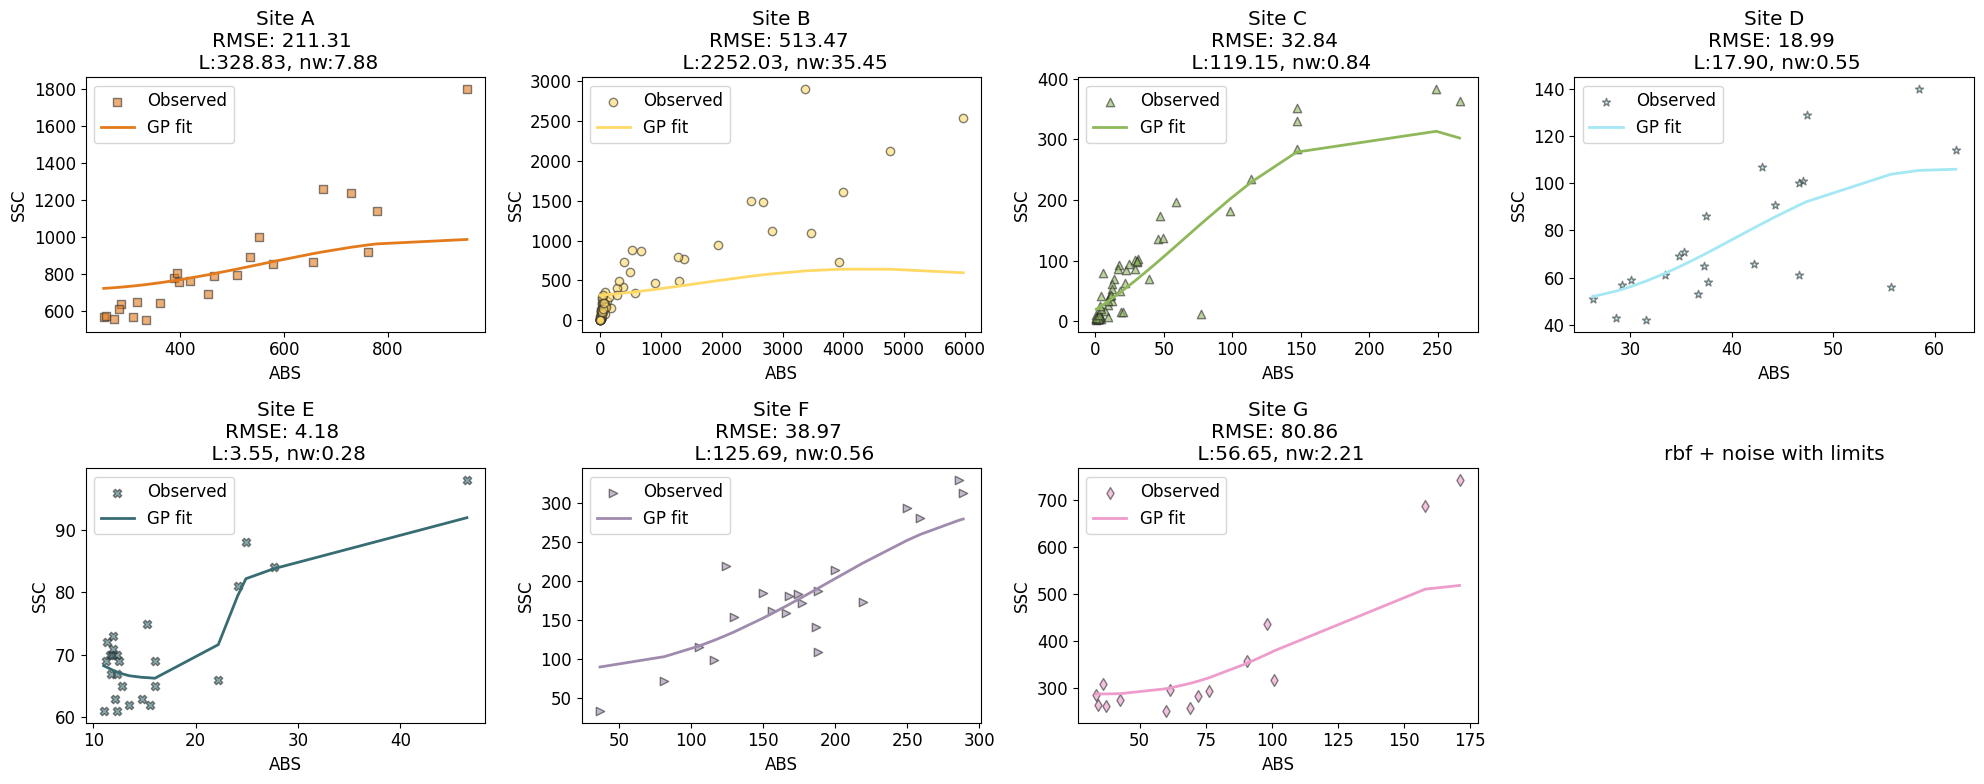

In [33]:
x_key = 'ABS'
y_key = 'SSC'

'''
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  '''

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    l = model['hyperparams']['rbf_l']
    nw = model['hyperparams']['noise_l']
    

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)

    ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f} \n L:{l:.2f}, nw:{nw:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.title('rbf + noise with limits')
plt.tight_layout()
plt.show()




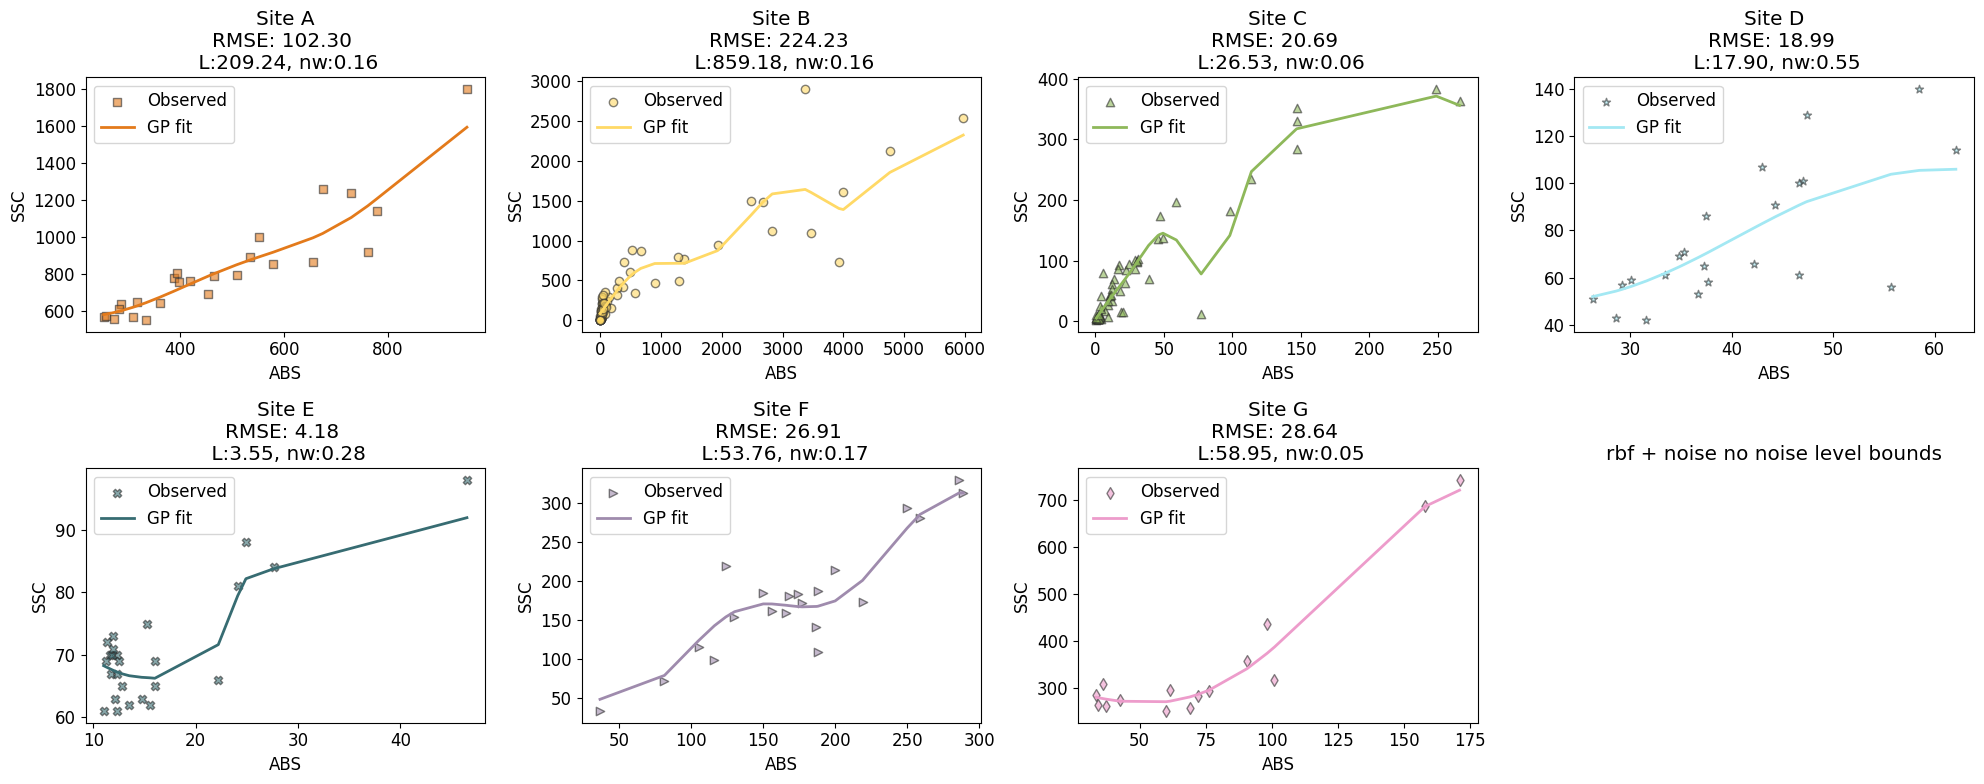

In [37]:
x_key = 'ABS'
y_key = 'SSC'

'''
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  '''

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    l = model['hyperparams']['rbf_l']
    nw = model['hyperparams']['noise_l']
    

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)

    ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f} \n L:{l:.2f}, nw:{nw:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.title('rbf + noise no noise level bounds')
plt.tight_layout()
plt.show()




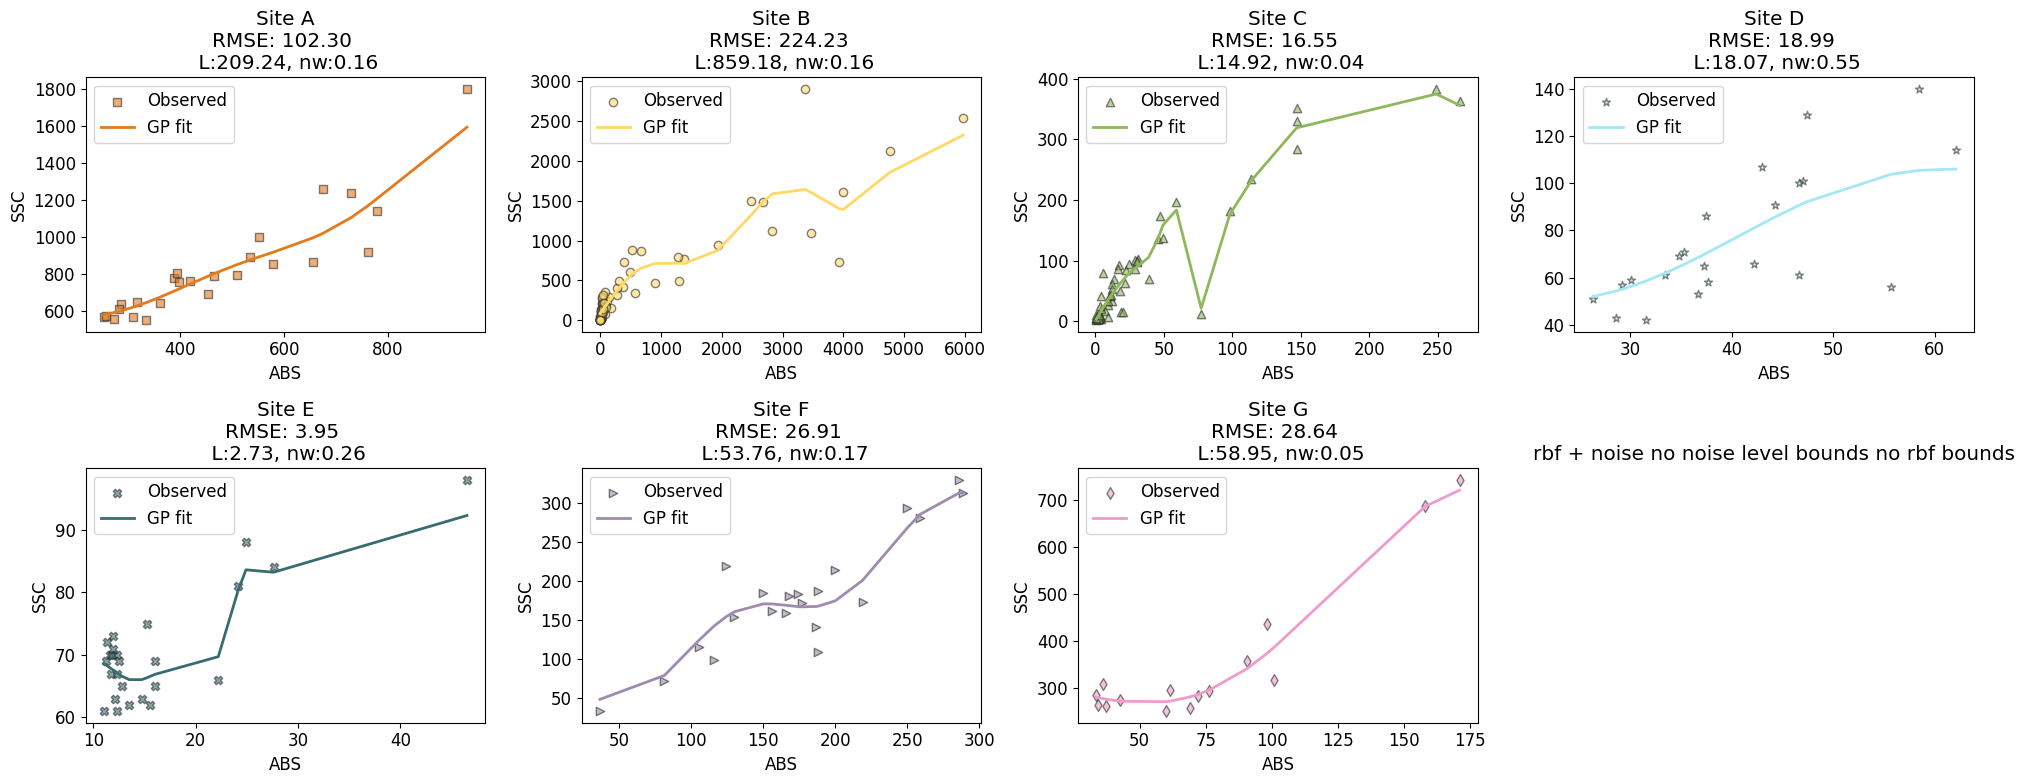

In [40]:
x_key = 'ABS'
y_key = 'SSC'

'''
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  '''

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    l = model['hyperparams']['rbf_l']
    nw = model['hyperparams']['noise_l']
    

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)

    ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f} \n L:{l:.2f}, nw:{nw:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.title('rbf + noise no noise level bounds no rbf bounds')
plt.tight_layout()
plt.show()




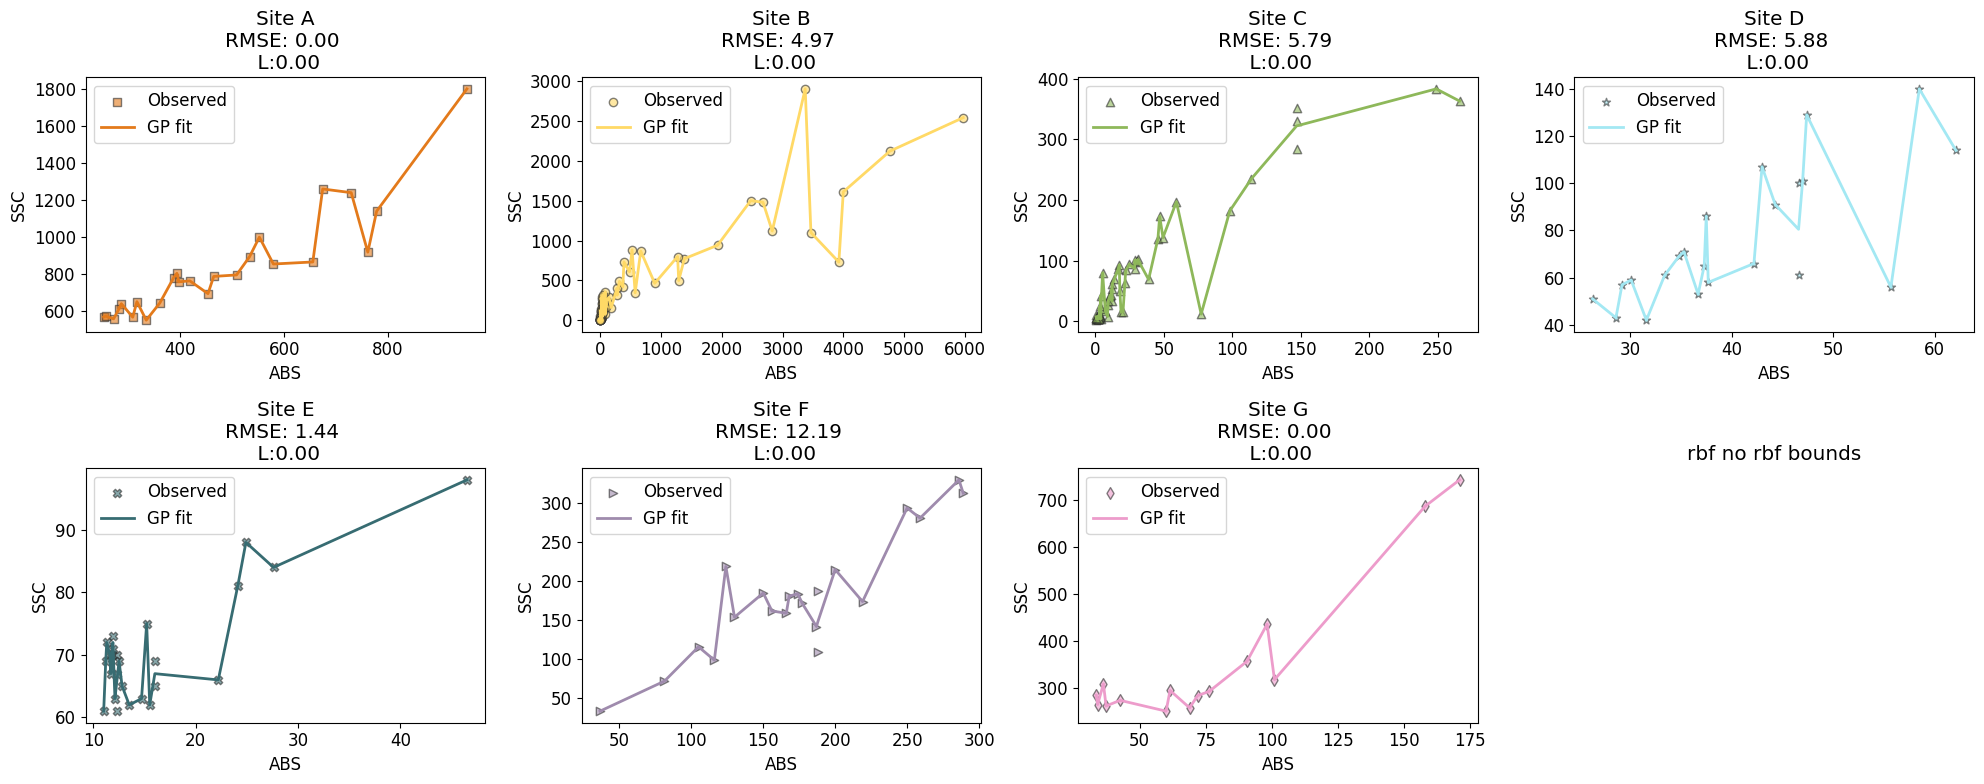

In [48]:
x_key = 'ABS'
y_key = 'SSC'

'''
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  '''

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    l = model['hyperparams']['rbf_l'][0]

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)

    ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f} \n L:{l:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.title('rbf no rbf bounds')
plt.tight_layout()
plt.show()




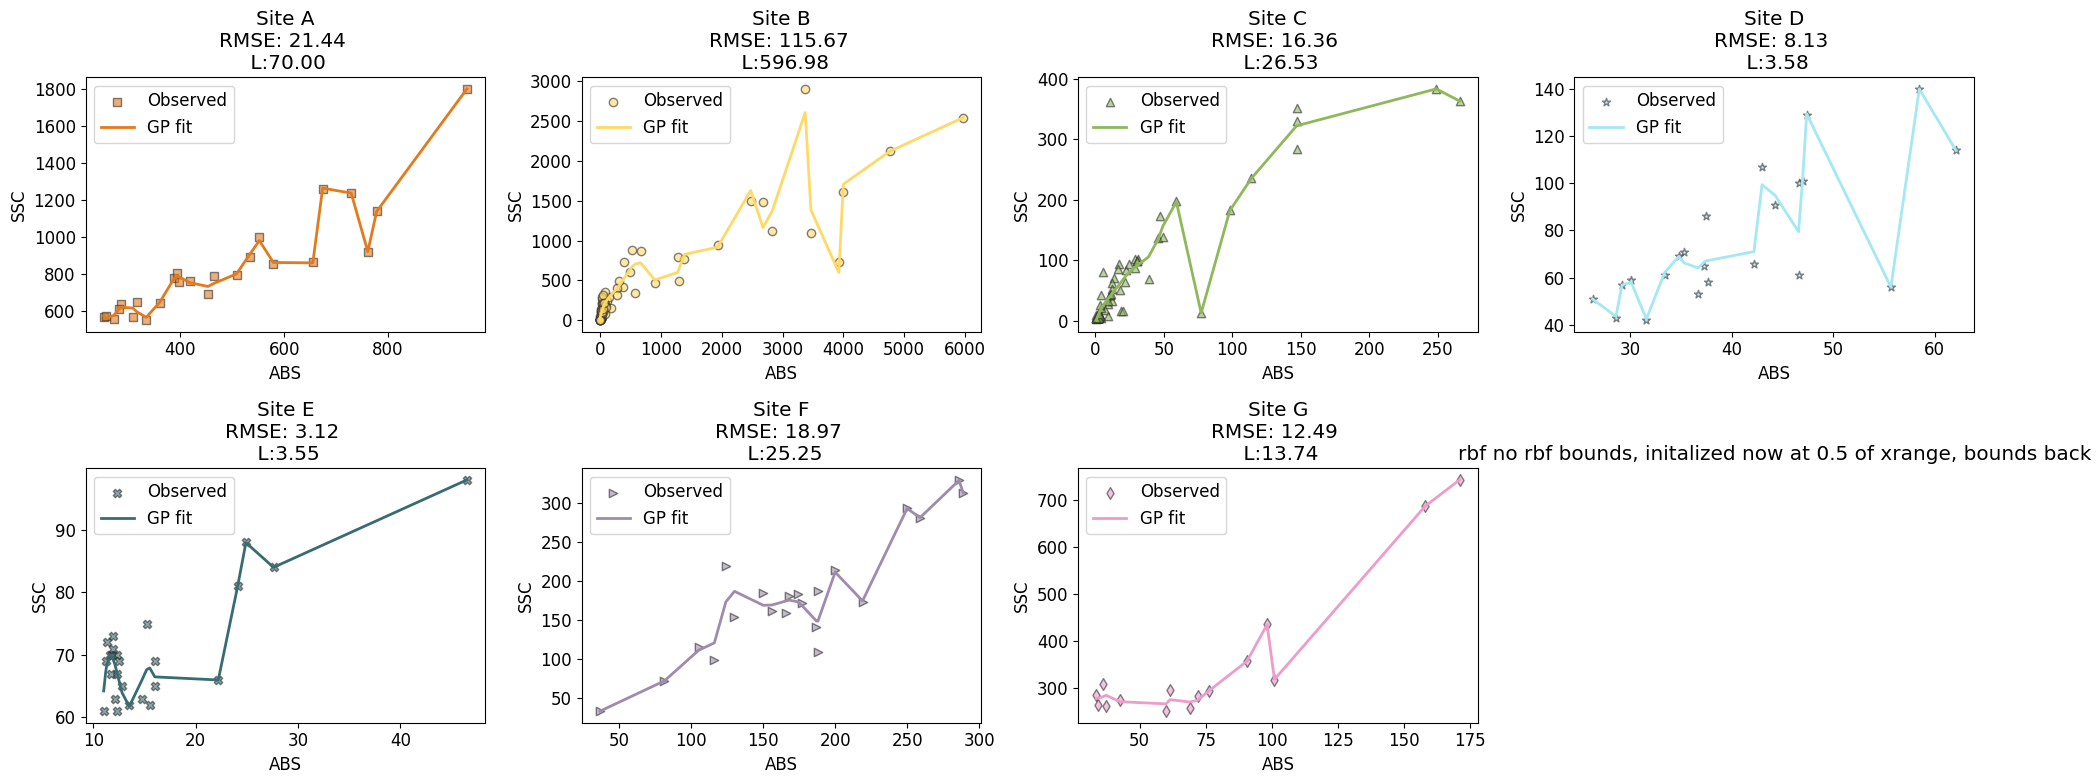

In [51]:
x_key = 'ABS'
y_key = 'SSC'

'''
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  '''

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    l = model['hyperparams']['rbf_l'][0]
    

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)

    ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f} \n L:{l:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.title('rbf no rbf bounds, initalized now at 0.5 of xrange, bounds back')
plt.tight_layout()
plt.show()




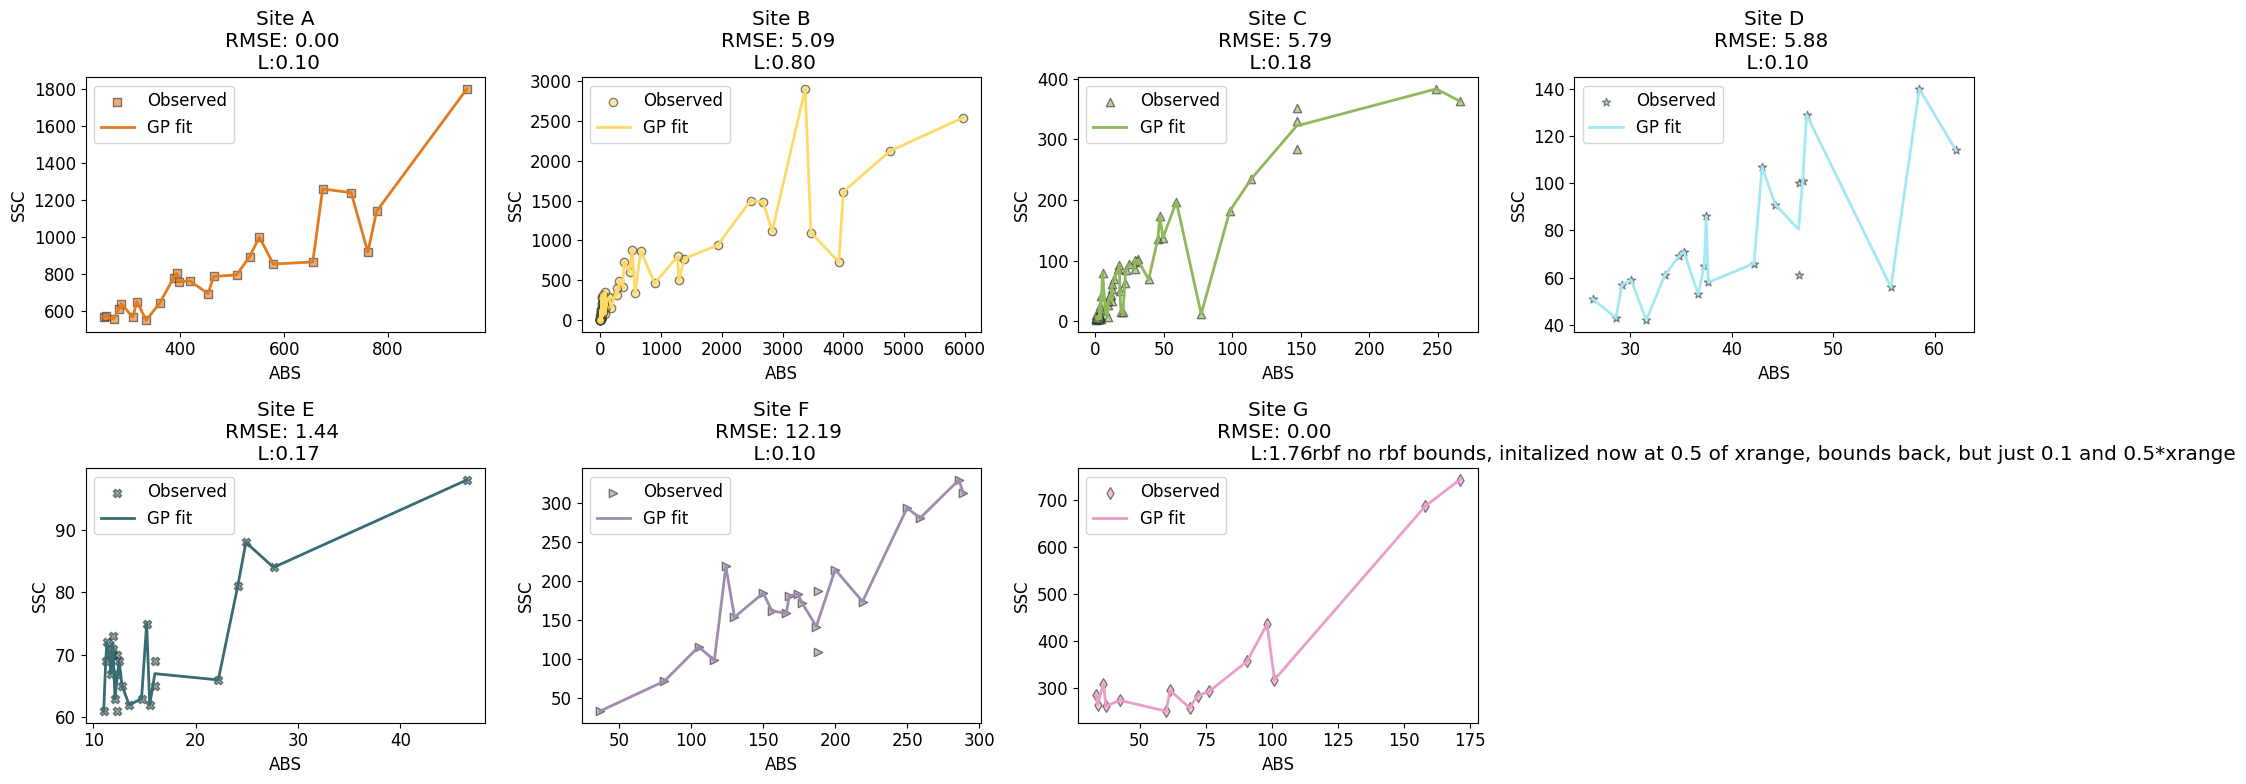

In [54]:
x_key = 'ABS'
y_key = 'SSC'

'''
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  '''

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    l = model['hyperparams']['rbf_l'][0]
    

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)

    ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f} \n L:{l:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.title('rbf no rbf bounds, initalized now at 0.5 of xrange, bounds back, but just 0.1 and 0.5*xrange')
plt.tight_layout()
plt.show()




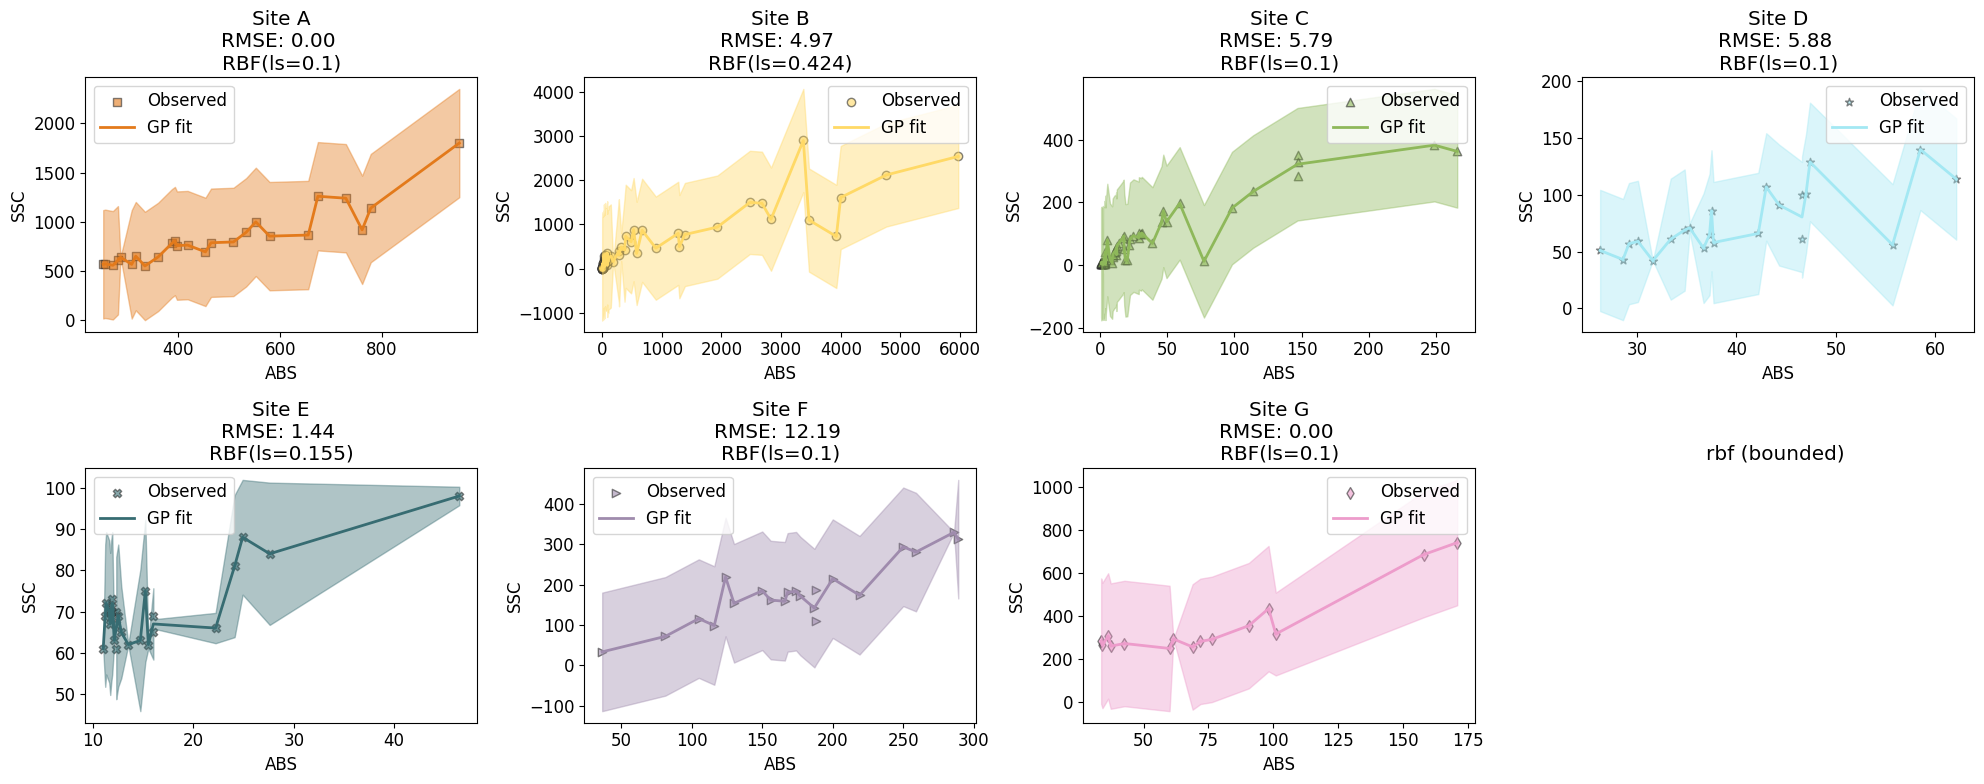

In [78]:
x_key = 'ABS'
y_key = 'SSC'

'''
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.5
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2
    

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  '''

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    # l = model['hyperparams']['rbf_l'][0]
    

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.4, color=color)

    try:
        kernel_used = model['model'].kernel_
        kernel_str = simplify_kernel_string(str(kernel_used))
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f} \n{kernel_str}"
    )
    # ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f} \n L:{l:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.title('rbf (bounded) ')
plt.tight_layout()
plt.show()




/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 350.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 2984.905. Increasing the bound and calling fit again may find a b

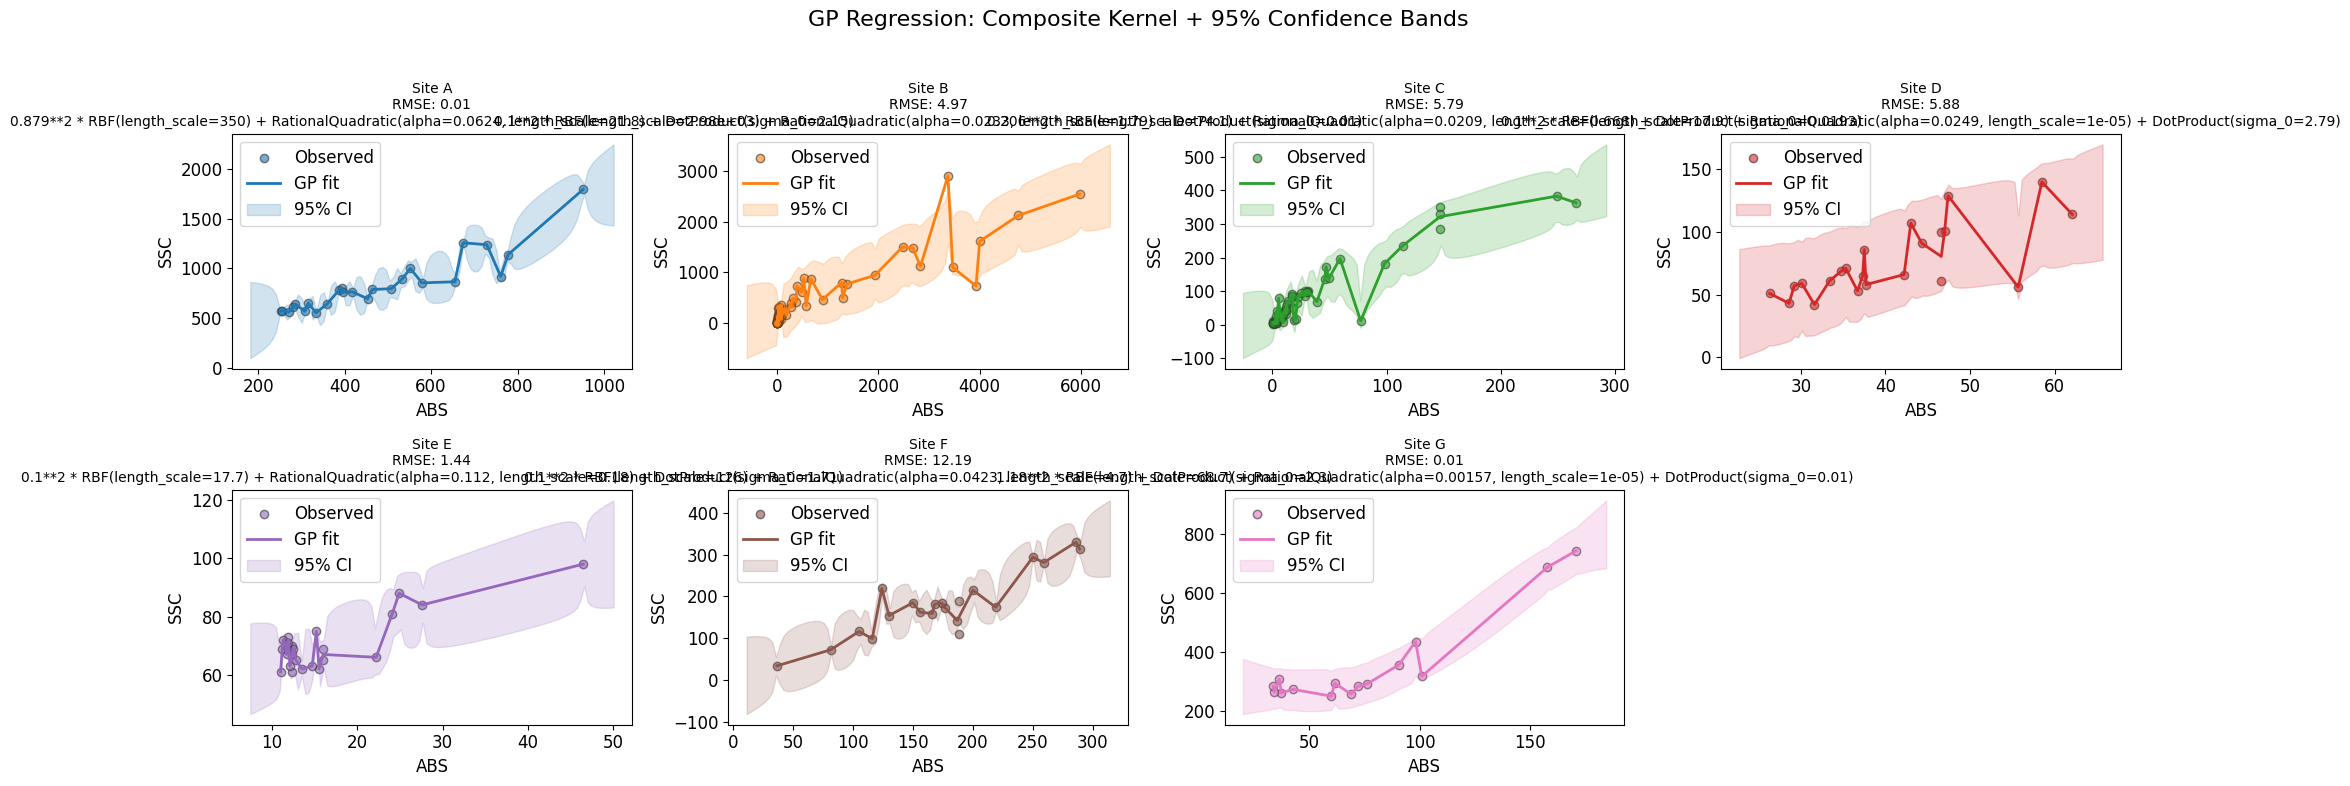

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic

# === Helper: Extract all hyperparameters from any composite kernel ===
def extract_kernel_hyperparams(kernel):
    params = {}
    def _extract(k, prefix=''):
        if hasattr(k, 'theta') and hasattr(k, 'hyperparameter_names'):
            for name, val in zip(k.hyperparameter_names, np.exp(k.theta)):
                params[f"{prefix}{name}"] = val
        if hasattr(k, 'k1'):
            _extract(k.k1, prefix + 'k1_')
        if hasattr(k, 'k2'):
            _extract(k.k2, prefix + 'k2_')
    _extract(kernel)
    return params

# === GP model ===
def GP(SAC_m, SSC_m, p, SAC_range=[None, None], SAC_log=False, SSC_log=False, hyperparams=-999):
    if SAC_range != [None, None]:
        min_SAC = np.array(SAC_range).min() - (0.1 * np.array(SAC_range).min())
        max_SAC = np.array(SAC_range).max() + (0.1 * np.array(SAC_range).max())
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()

    x_range = max_SAC - min_SAC
    min_l = 0.1
    max_l = x_range * 0.5
    noise_std = max(np.std(SSC_m), 1e-6)
    low = (0.01 * noise_std) ** 2
    high = (0.2 * noise_std) ** 2

    if hyperparams == -999:
        kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=x_range * 0.5, length_scale_bounds=(min_l, max_l)) \
                 + RationalQuadratic(length_scale=1.0, alpha=0.1) \
                 + DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-2, 1e2))
    else:
        l = hyperparams[0]
        kernel = RBF(l, length_scale_bounds="fixed")

    X = np.array(SAC_m).reshape(-1, 1)
    y = SSC_m

    if SAC_log:
        min_SAC = np.log10(min_SAC)
        max_SAC = np.log10(max_SAC)
        X = np.log10(X)
    if SSC_log:
        y = np.log10(SSC_m + 1e-6)

    SAC_pred = np.linspace(min_SAC-0.1*x_range, max_SAC+0.1*x_range, p)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=1e-5)
    gpr = gaussian_process.fit(X, y)

    try:
        GP_score = gpr.score(X, y)
    except ValueError:
        GP_score = np.nan

    GP_logmarg = gpr.log_marginal_likelihood()
    Y_pred, std = gpr.predict(SAC_pred.reshape(-1, 1), return_std=True)

    return SAC_pred, Y_pred, std, GP_score, GP_logmarg, gpr

# === Main loop ===
model_dictionary = {}
x_key = 'ABS'
y_key = 'SSC'

for i, site_id in enumerate(alpha_site_id):
    site_data = lisst_data_dict[site_id]
    xdata = site_data[x_key].to_numpy()
    ydata = site_data[y_key].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model = GP(xdata, ydata, p)

    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)

    ypred, std_pred = GP_model.predict(xdata.reshape(-1, 1), return_std=True)
    MSE_all = np.square(np.subtract(ydata, ypred)).mean()
    rmse_all = math.sqrt(MSE_all)
    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))

    model_dictionary[site_id] = {
        'hyperparams': kernel_params,
        'num_samp': len(xdata),
        'x': xdata,
        'y': ydata,
        'n_pred': ypred,
        'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
        'scores': {
            'GP_score': GP_score_all,
            'GP_logmarg': GP_logmarg_all,
            'r_score': r_score_all,
            'rmse': rmse_all,
            'std': std_pred
        },
        'model': GP_model
    }

# === Plotting ===
site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]
    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']

    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]

    color = f"C{i % 10}"
    marker = 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    ax.fill_between(SAC_pred_all,
                    SSC_pred_all - 1.96 * std_all,
                    SSC_pred_all + 1.96 * std_all,
                    color=color, alpha=0.2, label='95% CI')

    try:
        kernel_str = str(model['model'].kernel_)
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}\n{kernel_str}",
        fontsize=10
    )
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Hide unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.suptitle('GP Regression: Composite Kernel + 95% Confidence Bands', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic
)

# Helper to extract hyperparameters from composite kernel

def extract_kernel_hyperparams(kernel):
    params = {}

    def _extract(k, prefix=''):
        if hasattr(k, 'theta') and hasattr(k, 'hyperparameter_names'):
            for name, val in zip(k.hyperparameter_names, np.exp(k.theta)):
                params[f"{prefix}{name}"] = val
        if hasattr(k, 'k1'):
            _extract(k.k1, prefix + 'k1_')
        if hasattr(k, 'k2'):
            _extract(k.k2, prefix + 'k2_')

    _extract(kernel)
    return params

# Gaussian Process Regression function

def GP(SAC_m, SSC_m, p, SAC_range=[None, None], SAC_log=False, SSC_log=False, hyperparams=-999):
    if SAC_range != [None, None]:
        min_SAC = np.array(SAC_range).min() - (0.1 * np.array(SAC_range).min())
        max_SAC = np.array(SAC_range).max() + (0.1 * np.array(SAC_range).max())
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()

    x_range = max_SAC - min_SAC
    output_var = np.var(SSC_m)
    input_mean = np.abs(np.mean(SAC_m))
    noise_std = max(np.std(SSC_m), 1e-6)
    min_noise = (0.05 * noise_std) ** 2
    max_noise = (0.5 * noise_std) ** 2
    



    if hyperparams == -999:
        kernel = (
            ConstantKernel(output_var, (0.05 * output_var, 5 * output_var)) *
            RBF(length_scale=0.5 * x_range, length_scale_bounds=(0.2 * x_range, 2.0 * x_range))
            # WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(min_noise, max_noise)) +
            # RationalQuadratic(length_scale=1.0, length_scale_bounds=(0.2 * x_range, 2.0 * x_range),
            #                  alpha=1.0, alpha_bounds=(0.1, 100.0)) 
            # DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1 * input_mean, 2 * input_mean))
        )
    else:
        l = hyperparams[0]
        kernel = RBF(l, length_scale_bounds="fixed")

    X = np.array(SAC_m).reshape(-1, 1)
    y = SSC_m

    if SAC_log:
        min_SAC = np.log10(min_SAC)
        max_SAC = np.log10(max_SAC)
        X = np.log10(X)
    if SSC_log:
        y = np.log10(SSC_m + 1e-6)

    SAC_pred = np.linspace(max(min_SAC-0.1*x_range,0), max_SAC+0.1*x_range, p)
    # SAC_pred = np.linspace(0, max_SAC+0.2*x_range, p)


    # Define possible alpha values to test
    alphas = [1e-10, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1.0]

    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    # Use GridSearchCV to find best alpha
    param_grid = {'alpha': alphas}
    search = GridSearchCV(gp, param_grid, cv=5)
    search.fit(X, y)

    # Best alpha
    best_alpha = search.best_params_['alpha']
    
    gp_best = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=best_alpha)
    gp_best.fit(X, y)

    score = gp_best.score(X, y)
    log_marg = gp_best.log_marginal_likelihood()
    Y_pred, std = gp_best.predict(SAC_pred.reshape(-1, 1), return_std=True)

    return SAC_pred, Y_pred, std, score, log_marg, gp_best, best_alpha

# Example usage (replace with your actual loop logic)
model_dictionary = {}
x_key = 'ABS'
y_key = 'SSC'

for i, site_id in enumerate(alpha_site_id):
    site_data = lisst_data_dict[site_id]
    xdata = site_data[x_key].to_numpy()
    ydata = site_data[y_key].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model, n_alpha = GP(xdata, ydata, p)
    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
    ypred, std_pred = GP_model.predict(xdata.reshape(-1, 1), return_std=True)

    MSE_all = np.square(np.subtract(ydata, ypred)).mean()
    rmse_all = math.sqrt(MSE_all)
    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))
    print(f"Site {site_id} - RMSE: {rmse_all:.2f}, R^2: {r_score_all:.2f}, Alpha: {n_alpha}")

    model_dictionary[site_id] = {
        'hyperparams': kernel_params,
        'num_samp': len(xdata),
        'x': xdata,
        'y': ydata,
        'n_pred': ypred,
        'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
        'scores': {
            'GP_score': GP_score_all,
            'GP_logmarg': GP_logmarg_all,
            'r_score': r_score_all,
            'rmse': rmse_all,
            'std': std_pred,
            'alpha': n_alpha
        },
        'model': GP_model
    }

# Plotting section remains as in your full script (not repeated here)


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 140.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    ht

Site A - RMSE: 96.11, R^2: -21.17, Alpha: 0.1
Site B - RMSE: 248.68, R^2: 0.63, Alpha: 0.2


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1772515.80449827. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1193.9620000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1772515.80449827. Increasing the bound and calling fit again m

Site C - RMSE: 28.58, R^2: 0.32, Alpha: 0.1
Site D - RMSE: 18.97, R^2: -3.51, Alpha: 1.0


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 386.832. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 7.1000000000000005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 7.1000000000000005. Decreasing the bound and calling fit again may find a

Site E - RMSE: 4.39, R^2: -0.57, Alpha: 0.2
Site F - RMSE: 34.85, R^2: 0.78, Alpha: 1.0
Site G - RMSE: 29.25, R^2: -74.10, Alpha: 0.1


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 281.10282312925165. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 281.10282312925165. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 505.0. Increasing the bound and calling fit again may find a

Site A model hyperparams: {}
Site B model hyperparams: {}
Site C model hyperparams: {}
Site D model hyperparams: {}
Site E model hyperparams: {}
Site F model hyperparams: {}
Site G model hyperparams: {}


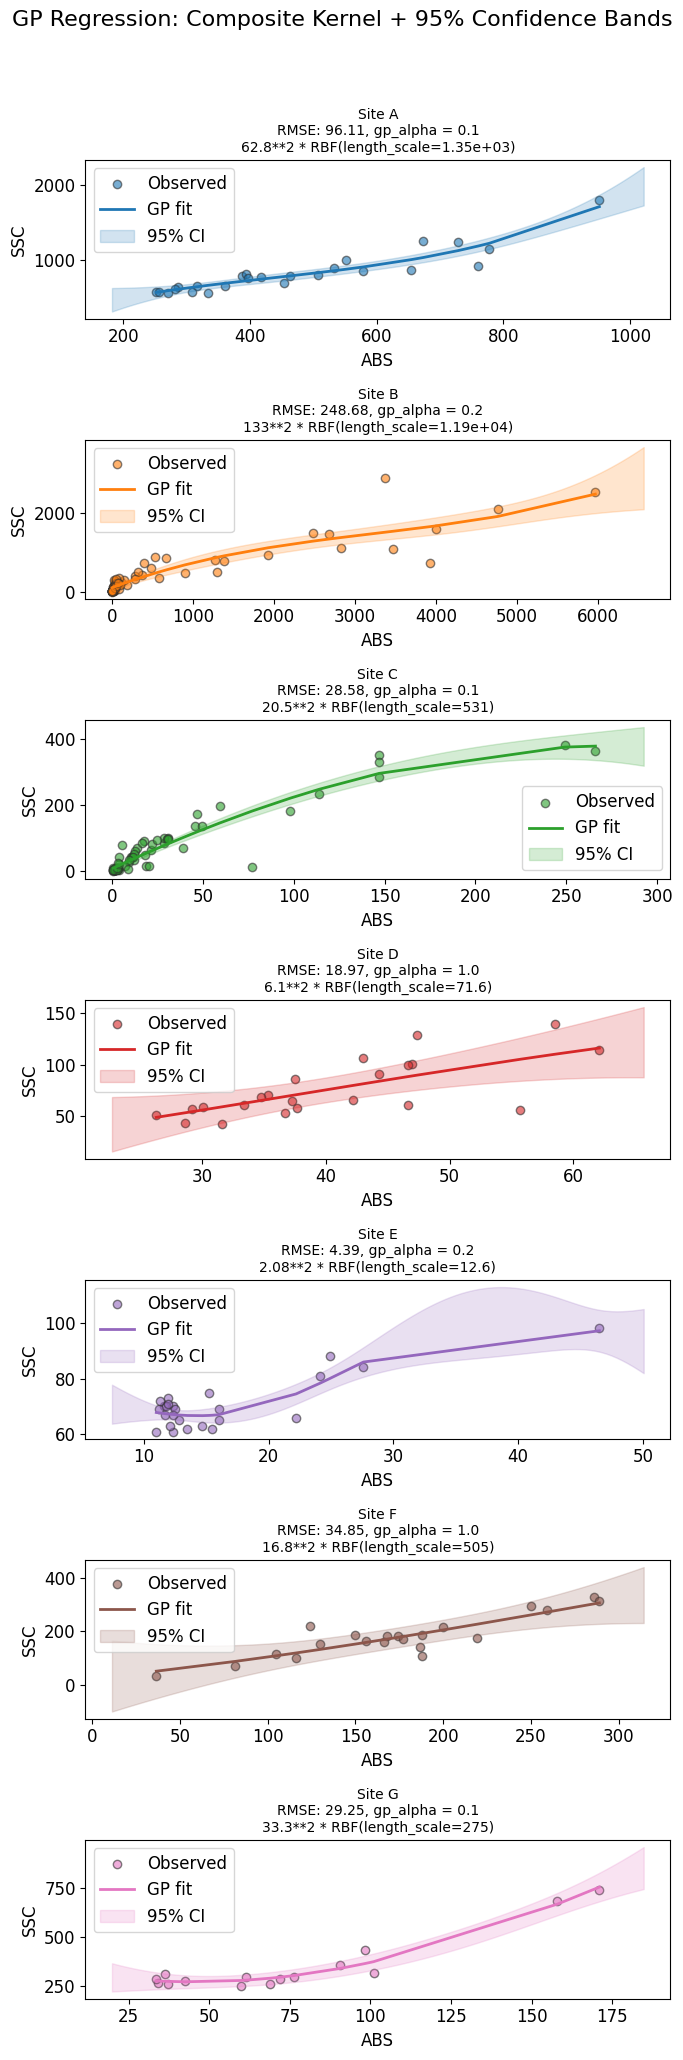

In [261]:
# === Plotting ===
site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 1
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7* n_cols, 3 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]
    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    gp_alpha = model['scores']['alpha']
    print(f'Site {site_id} model hyperparams: {model["hyperparams"]}')

    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]

    color = f"C{i % 10}"
    marker = 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    ax.fill_between(SAC_pred_all,
                    SSC_pred_all - 1.96 * std_all,
                    SSC_pred_all + 1.96 * std_all,
                    color=color, alpha=0.2, label='95% CI')

    try:
        kernel_str = str(model['model'].kernel_)
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha}\n{kernel_str}",
        fontsize=10
    )
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Hide unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.suptitle('GP Regression: Composite Kernel + 95% Confidence Bands', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic
)

# Helper to extract hyperparameters from composite kernel

def extract_kernel_hyperparams(kernel):
    params = {}

    def _extract(k, prefix=''):
        if hasattr(k, 'theta') and hasattr(k, 'hyperparameter_names'):
            for name, val in zip(k.hyperparameter_names, np.exp(k.theta)):
                params[f"{prefix}{name}"] = val
        if hasattr(k, 'k1'):
            _extract(k.k1, prefix + 'k1_')
        if hasattr(k, 'k2'):
            _extract(k.k2, prefix + 'k2_')

    _extract(kernel)
    return params

# Gaussian Process Regression function

def GP(SAC_m, SSC_m, p, SAC_log=False, SSC_log=False, hyperparams=-999):
    # ---- Normalize x using min-max ----
    min_SAC = SAC_m.min()
    max_SAC = SAC_m.max()
    x_range = max_SAC - min_SAC
    if x_range < 1e-8:
        raise ValueError("Input x has too small a range to normalize reliably.")
    X = ((SAC_m - min_SAC) / x_range).reshape(-1, 1)

    # ---- Normalize y using min-max ----
    min_SSC = SSC_m.min()
    max_SSC = SSC_m.max()
    y_range = max_SSC - min_SSC
    if y_range < 1e-8:
        raise ValueError("Target y has too small a range to normalize reliably.")
    y = ((SSC_m - min_SSC) / y_range).reshape(-1, 1)

    if SAC_log:
        X = np.log10(X + 1e-8)
    if SSC_log:
        y = np.log10(y + 1e-6)

    # Kernel setup
    input_mean = np.abs(np.mean(X))
    noise_std = max(np.std(y), 1e-6)

    if hyperparams == -999:
        kernel = (
            ConstantKernel(0.3, (0.05, 0.8)) *
            RBF(length_scale=0.5, length_scale_bounds=(0.3, 2)) 
            # DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1 , 2))
            # RationalQuadratic(length_scale=0.5, length_scale_bounds=(0.3, 1),
            #                  alpha=1.0, alpha_bounds=(0.1, 100.0)) 
        )
    else:
        l = hyperparams[0]
        kernel = RBF(l, length_scale_bounds="fixed")

    SAC_pred = np.linspace(0, 1, p).reshape(-1, 1)

    # Fit with cross-validated alpha
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    # since envrionmental data, trying to find best alpha (noise) but have it not be too low
    alphas = np.logspace(-2, -1, 10)
    search = GridSearchCV(gp, {'alpha': alphas}, cv=5)
    search.fit(X, y.ravel())

    best_alpha = search.best_params_['alpha']
    gp_best = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=best_alpha)
    gp_best.fit(X, y.ravel())

    Y_pred_scaled, std_scaled = gp_best.predict(SAC_pred, return_std=True)

    # Invert y-scaling
    Y_pred_orig = Y_pred_scaled * y_range + min_SSC
    std_orig = std_scaled * y_range

    # Invert x-scaling for plotting
    SAC_pred_orig = SAC_pred.ravel() * x_range + min_SAC

    score = gp_best.score(X, y.ravel())
    log_marg = gp_best.log_marginal_likelihood()

    return SAC_pred_orig, Y_pred_orig, std_orig, score, log_marg, gp_best, best_alpha, (min_SAC, x_range), (min_SSC, y_range)


# Example usage (replace with your actual loop logic)
model_dictionary = {}
x_key = 'ABS'
y_key = 'SSC'

for i, site_id in enumerate(alpha_site_id):
    site_data = lisst_data_dict[site_id]
    xdata = site_data[x_key].to_numpy()
    ydata = site_data[y_key].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model, n_alpha, x_scale, y_scale = GP(xdata, ydata, p)
    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
    x_min, x_range = x_scale
    x_scaled = (xdata - x_min) / x_range
    ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)
    
    y_min, y_range = y_scale
    ypred = ypred_scaled * y_range + y_min
    std_pred = std_pred_scaled * y_range

    MSE_all = np.square(np.subtract(ydata, ypred)).mean()
    rmse_all = math.sqrt(MSE_all)
    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))
    print(f"Site {site_id} - RMSE: {rmse_all:.2f}, R^2: {r_score_all:.2f}, Alpha: {n_alpha}")

    model_dictionary[site_id] = {
        'hyperparams': kernel_params,
        'num_samp': len(xdata),
        'x': xdata,
        'y': ydata,
        'n_pred': ypred,
        'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
        'scores': {
            'GP_score': GP_score_all,
            'GP_logmarg': GP_logmarg_all,
            'r_score': r_score_all,
            'rmse': rmse_all,
            'std': std_pred,
            'alpha': n_alpha,
        },
        'model': GP_model,
        'x_scaling': x_scale,  # (min_SAC, x_range)
        'y_scaling': y_scale,  # (min_SSC, y_range)
    }



/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn

Site A - RMSE: 118.60, R^2: -8.73, Alpha: 0.03593813663804628


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site B - RMSE: 261.05, R^2: -0.50, Alpha: 0.021544346900318832
Site C - RMSE: 28.76, R^2: -0.48, Alpha: 0.01
Site D - RMSE: 19.21, R^2: -7.85, Alpha: 0.1


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

Site E - RMSE: 4.38, R^2: -64.13, Alpha: 0.01
Site F - RMSE: 38.32, R^2: -5.77, Alpha: 0.1


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn

Site G - RMSE: 28.66, R^2: -5.65, Alpha: 0.01291549665014884


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Site A model hyperparams: {}
Site B model hyperparams: {}
Site C model hyperparams: {}
Site D model hyperparams: {}
Site E model hyperparams: {}
Site F model hyperparams: {}
Site G model hyperparams: {}


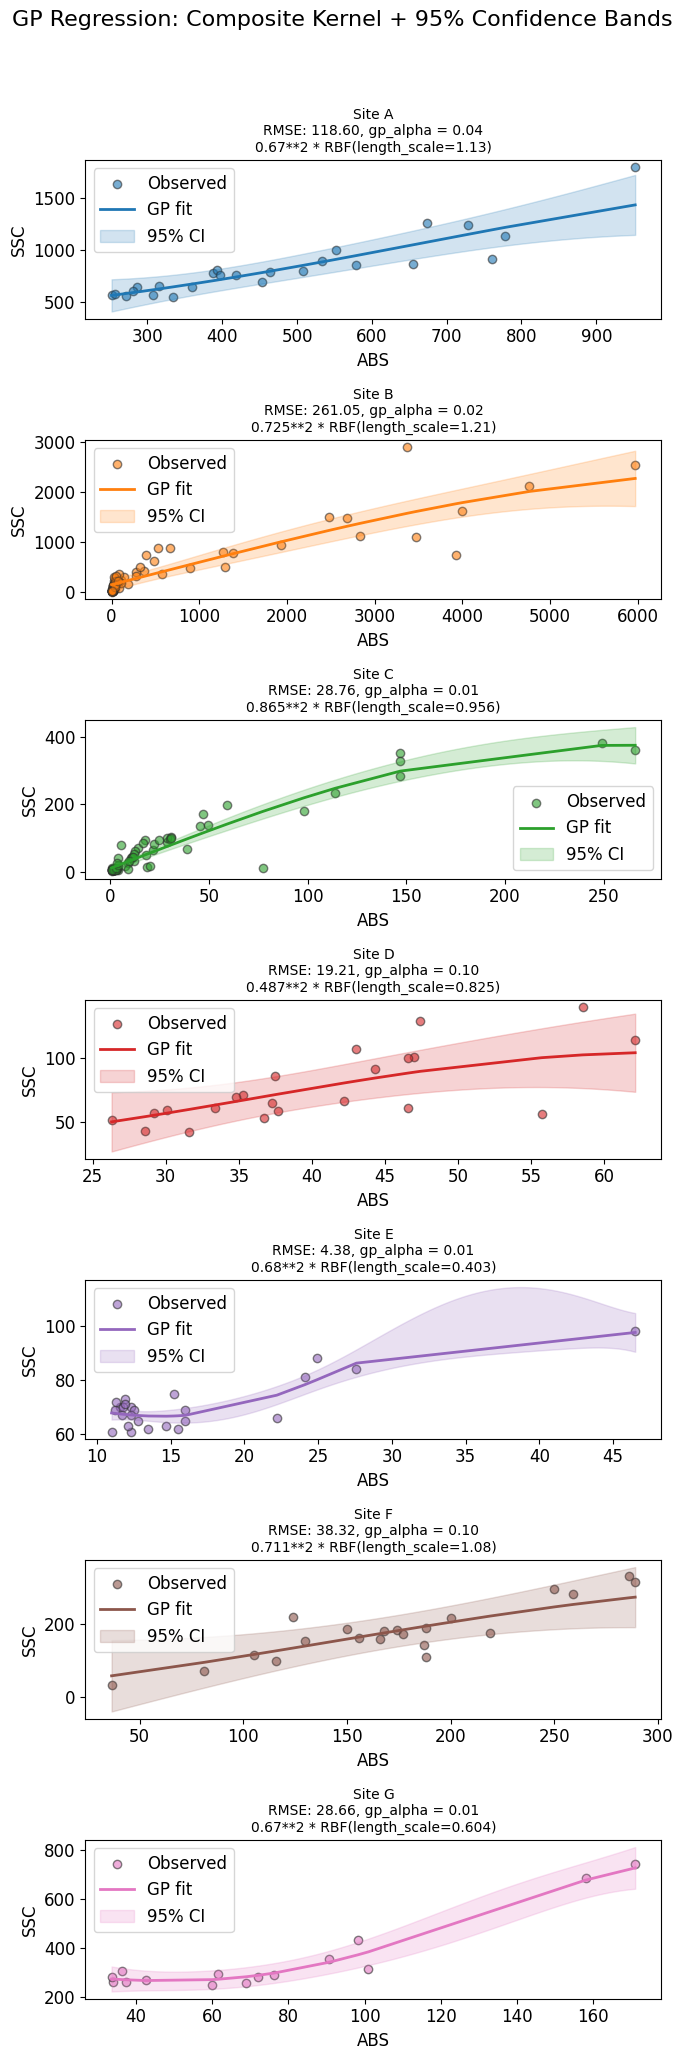

In [312]:
# === Plotting ===
site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 1
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7* n_cols, 3 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]
    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    gp_alpha = model['scores']['alpha']
    print(f'Site {site_id} model hyperparams: {model["hyperparams"]}')

    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]

    color = f"C{i % 10}"
    marker = 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    ax.fill_between(SAC_pred_all,
                    SSC_pred_all - 1.96 * std_all,
                    SSC_pred_all + 1.96 * std_all,
                    color=color, alpha=0.2, label='95% CI')

    try:
        kernel_str = str(model['model'].kernel_)
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha:.2f}\n{kernel_str}",
        fontsize=10
    )
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Hide unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.suptitle('GP Regression: Composite Kernel + 95% Confidence Bands', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(<Figure size 700x500 with 1 Axes>, <Figure size 700x500 with 1 Axes>)

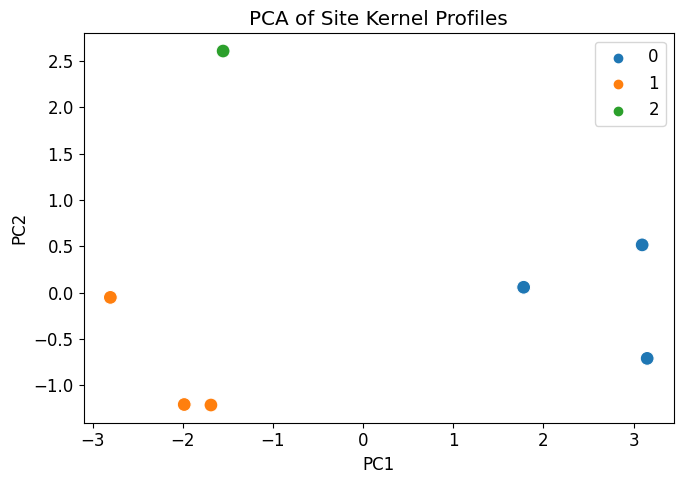

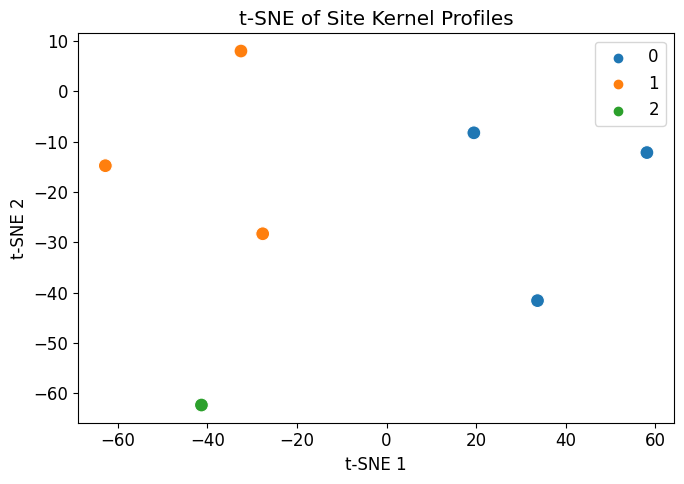

In [314]:
# Re-import necessary libraries after code execution environment reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Simulated kernel profile table (replace with actual values later)
# Columns: alpha, const, l, l/const, l/const^2, l*const, const*l^2, const^2/l
site_names = ['b', 'c', 'f','a', 'e', 'd', 'g']
data = np.array([
    [0.02, 0.725, 1.21, 1.6689, 2.3020, 0.877, 0.636, 1.061],
    [0.01, 0.865, 0.956, 1.1052, 1.2776, 0.827, 0.715, 0.790],
    [0.1, 0.711, 1.08, 1.5190, 2.1364, 0.768, 0.546, 0.829],
    [0.04, 0.670, 1.13, 1.6866, 2.5172, 0.757, 0.507, 0.855],
    [0.01, 0.680, 0.403, 0.5926, 0.8715, 0.274, 0.186, 0.110],
    [0.1, 0.680, 0.405, 0.5956, 0.8758, 0.275, 0.187, 0.111],
    [0.01, 0.670, 0.604, 0.9015, 1.3455, 0.405, 0.271, 0.244]
])

labels = ['alpha', 'const', 'l', 'l/const', 'l/const^2', 'l*const', 'const*l^2', 'const^2/l']

# Scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
# data_scaled = data

# PCA for 2D projection
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# t-SNE for nonlinear structure
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(data_scaled)

# KMeans clustering (you can adjust n_clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Plot PCA
fig_pca, ax_pca = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_pca)
ax_pca.set_title("PCA of Site Kernel Profiles")
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")

# Plot t-SNE
fig_tsne, ax_tsne = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_tsne)
ax_tsne.set_title("t-SNE of Site Kernel Profiles")
ax_tsne.set_xlabel("t-SNE 1")
ax_tsne.set_ylabel("t-SNE 2")

fig_pca.tight_layout()
fig_tsne.tight_layout()
fig_pca, fig_tsne


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


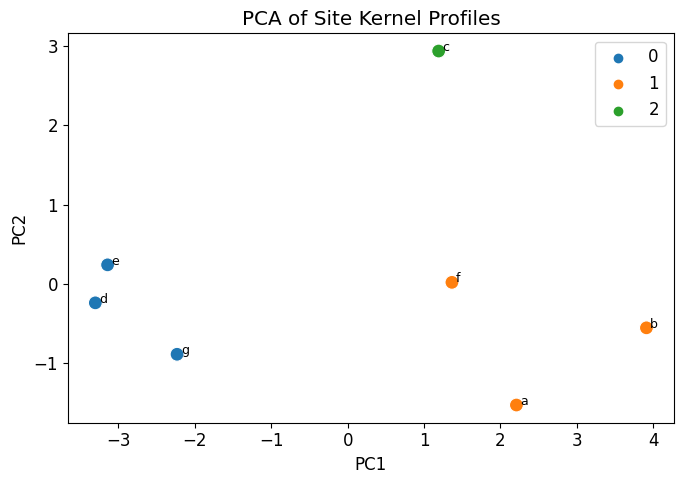

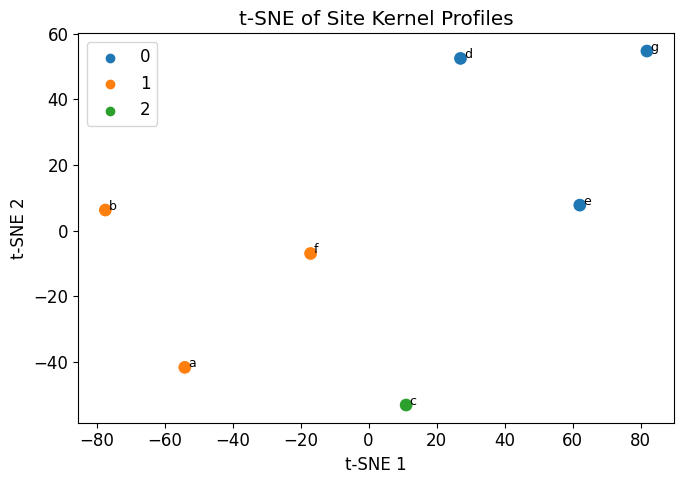

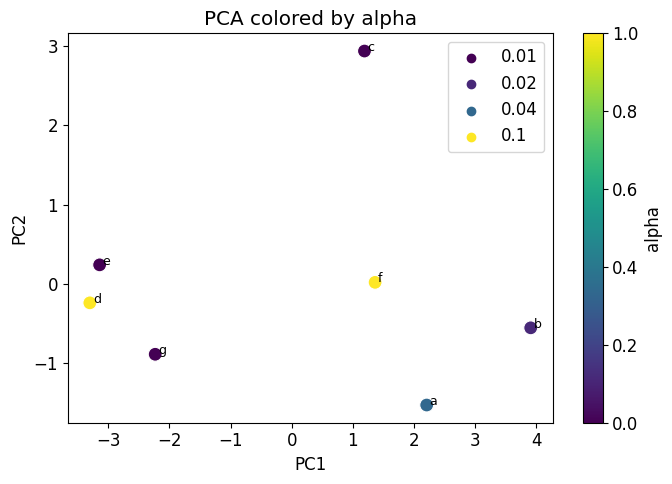

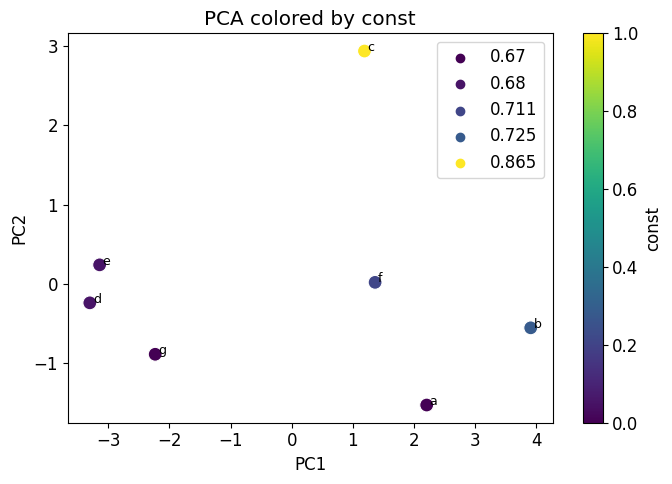

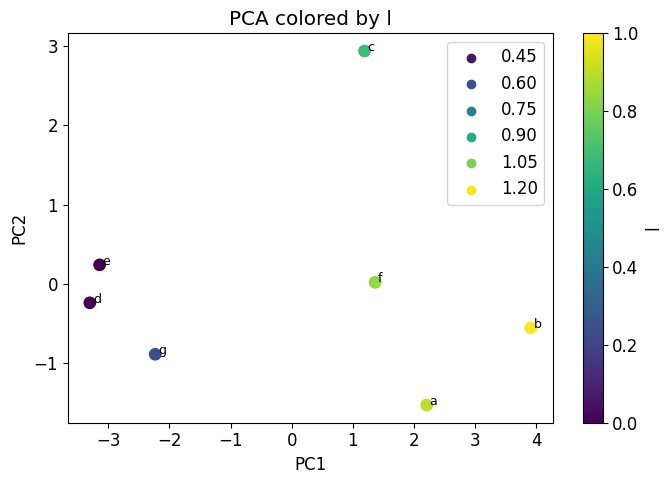

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Simulated kernel profile table (replace with actual values later)
site_names = ['b', 'c', 'f','a', 'e', 'd', 'g']
data = np.array([
    [0.02, 0.725, 1.21, 1.6689, 2.3020, 0.877, 0.636, 1.061, 0.33,	6000,	2000],
    [0.01, 0.865, 0.956, 1.1052, 1.2776, 0.827, 0.715, 0.790, 1.33,	300,	400],
    [0.1, 0.711, 1.08, 1.5190, 2.1364, 0.768, 0.546, 0.829, 1.33,	300,	400],
    [0.04, 0.670, 1.13, 1.6866, 2.5172, 0.757, 0.507, 0.855, 2, 1000, 2000],
    [0.01, 0.680, 0.403, 0.5926, 0.8715, 0.274, 0.186, 0.110, 2, 50, 100],
    [0.1, 0.680, 0.405, 0.5956, 0.8758, 0.275, 0.187, 0.111, 2.5, 60, 150],
    [0.01, 0.670, 0.604, 0.9015, 1.3455, 0.405, 0.271, 0.244, 4.57, 175, 800]
])
labels = ['alpha', 'const', 'l', 'l/const', 'l/const^2', 'l*const', 'const*l^2', 'const^2/l', 'X/Y', 'maxX','maxY]']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(data_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# --- PCA plot with labels ---
fig_pca, ax_pca = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_pca)
for i, txt in enumerate(site_names):
    ax_pca.text(pca_result[i, 0]+0.05, pca_result[i, 1], txt, fontsize=9)
ax_pca.set_title("PCA of Site Kernel Profiles")
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")

# --- t-SNE plot with labels ---
fig_tsne, ax_tsne = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_tsne)
for i, txt in enumerate(site_names):
    ax_tsne.text(tsne_result[i, 0]+1.0, tsne_result[i, 1], txt, fontsize=9)
ax_tsne.set_title("t-SNE of Site Kernel Profiles")
ax_tsne.set_xlabel("t-SNE 1")
ax_tsne.set_ylabel("t-SNE 2")

fig_pca.tight_layout()
fig_tsne.tight_layout()

# --- Optional: PCA plots colored by feature (e.g., alpha, const, l) ---
features_to_color = ['alpha', 'const', 'l']
for idx, feature in enumerate(features_to_color):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                    hue=data[:, idx], palette="viridis", s=100, ax=ax)
    for i, txt in enumerate(site_names):
        ax.text(pca_result[i, 0]+0.05, pca_result[i, 1], site_names[i], fontsize=9)
    ax.set_title(f"PCA colored by {feature}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    plt.colorbar(ax.collections[0], label=feature)
    plt.tight_layout()

plt.show()
